Event Feature Extraction
========================

In this tutorial, we introduce a few feature extraction techniques. Let's start by loading some data:

In [39]:
from skpm.event_logs import split, BPI17
from skpm.feature_extraction import TimestampExtractor

# download the dataset
log = BPI17()
log

BPI17 Event Log
    Cases: 31,509
    Events: 1,202,267
    Activities: 26

We'll use the unbiased split strategy in this tutorial and extract features accordingly.

In [40]:
train, test = split.unbiased(log.dataframe, **log.unbiased_split_params)

## Time-related features

In [41]:
te = TimestampExtractor().fit(train)
train[te.get_feature_names_out()] = te.transform(train)
test[te.get_feature_names_out()] = te.transform(test)

train.shape, test.shape

((805809, 33), (294882, 33))

In the literature, features like the weekday are usually extracted as a categorical features, but we currently implement it as a numerical by normalizing the values between `[-0.5, 0.5]`. In the future, we intend to provide a parameter to choose between the two options.

In [42]:
train.loc[0, te.get_feature_names_out()].T

accumulated_time                0.0
execution_time                0.048
remaining_time          1144676.119
day_of_month                   -0.5
day_of_week                0.166667
day_of_year                    -0.5
hour_of_day               -0.108696
min_of_hour                0.364407
month_of_year                  -0.5
numerical_timestamp    1451641875.0
sec_of_min                -0.245763
secs_since_sunday         -0.441344
secs_within_day            -0.08941
week_of_year                    0.5
Name: 0, dtype: object

## Resource-related features

The resource pool extractor is a feature extractor that identifies
resource roles based on the correlation between activities and resources.
You can easily use this function as shown below:


In [43]:
from skpm.feature_extraction import ResourcePoolExtractor

re = ResourcePoolExtractor(threshold=0.7).fit(train)
train["resource_role"] = re.transform(train)

train["resource_role"].value_counts()

resource_role
2    710158
1     94110
3      1522
4        17
5         2
Name: count, dtype: int64

The `threshold` defines the minimum correlation required to assign a role between a resource and an activity.

In [44]:
ResourcePoolExtractor(threshold=0.9).fit_transform(train).value_counts()

resource_roles
2                 407870
3                 301954
1                  94110
4                   1522
9                    266
5                     36
8                     32
6                     17
7                      2
Name: count, dtype: int64

From the machine learning perspective, it can be seen as a nice way
to encode the resource information and reduce the dimensionality of the
data. In this example (`threshold=0.7`), we grouped 133 resource labels into 5 roles:

<BarContainer object of 2 artists>

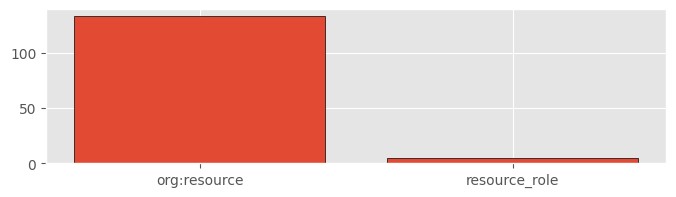

In [45]:
import matplotlib.pyplot as plt
from skpm.config import EventLogConfig as elc
plt.style.use("ggplot")

features = train[[elc.resource, "resource_role"]].nunique().index.values
values = train[[elc.resource, "resource_role"]].nunique().values

plt.figure(figsize=(8,2))
plt.bar(features, values, edgecolor="black")

## Inter-case features

Inter-case features refer to features that are computed based on the
relationship between different cases. It aims to quantify and module
the resource sharing between cases, for instance. In the current version
of our library, we only have a simple example of such feature: the number of
cases in progress simultaneously. This feature is commonly called
work in progress.

Let's see how it works:

Text(0.5, 1.0, 'Average daily \nWork in Progress (WIP) over time')

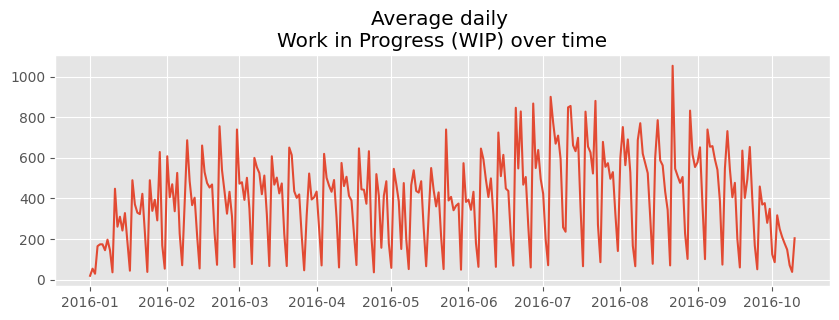

In [46]:
import pandas as pd
from skpm.feature_extraction import WorkInProgress

wip = WorkInProgress()
wip.fit(train)
train["wip"] = wip.transform(train)

data = (
    train
    .set_index(elc.timestamp)
    .resample("D")[["wip"]]
    .mean()
    .reset_index()
)
plt.figure(figsize=(10, 3))
plt.plot(pd.to_datetime(data[elc.timestamp]), data["wip"])
plt.title("Average daily \nWork in Progress (WIP) over time")

In this tutorial, we showed how to extract features from timestamps,
resources, and the inter-case perspective. We hope you find it useful
for your projects. If you have any questions or suggestions, please
open an issue on our GitHub repository.

In [48]:
train.head().T

,0,1,2,3,4
Action,Created,statechange,Created,Deleted,Created
org:resource,User_1,User_1,User_1,User_1,User_1
concept:name,A_Create Application,A_Submitted,W_Handle leads,W_Handle leads,W_Complete application
EventOrigin,Application,Application,Workflow,Workflow,Workflow
EventID,Application_652823628,ApplState_1582051990,Workitem_1298499574,Workitem_1673366067,Workitem_1493664571
lifecycle:transition,complete,complete,schedule,withdraw,schedule
time:timestamp,2016-01-01 09:51:15.304000,2016-01-01 09:51:15.352000,2016-01-01 09:51:15.774000,2016-01-01 09:52:36.392000,2016-01-01 09:52:36.403000
case:LoanGoal,Existing loan takeover,Existing loan takeover,Existing loan takeover,Existing loan takeover,Existing loan takeover
case:ApplicationType,New credit,New credit,New credit,New credit,New credit
case:concept:name,Application_652823628,Application_652823628,Application_652823628,Application_652823628,Application_652823628
